## Logistic Regression on Copy Number Variation and RNAseq

In [1]:
import pandas as pd

In [2]:
#Import Data
y = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/CancerTypes_y.txt', sep = '\t', header = None)
x_cnv = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/CNV_processed.txt', sep = '\t', header = 0)
x_rna = pd.read_table('/Users/a.su/Documents/Cancer_RNAseq_CNV/RNAseq_processed.txt', sep = '\t', header = 0)

In [3]:
# Remove GeneID Column
x_cnv = x_cnv.drop('GeneID', axis = 1)
x_rna = x_rna.drop('GeneID', axis = 1)
# Transpose
x_cnv = x_cnv.transpose()
x_rna = x_rna.transpose()
print('x_cnv shape is:', x_cnv.shape)
print('x_rna shape is:', x_rna.shape)
print('y shape is:', y.shape)

x_cnv shape is: (668, 26094)
x_rna shape is: (668, 26094)
y shape is: (668, 1)


#### DropNa from CNV data

In [4]:
#Merge CNV x and y data
cnv = x_cnv.reset_index(drop = True)
cnv['y'] = y[0]

#Delete Rows that contain NaN values
cnv_clean = cnv.dropna('index')
print(cnv_clean.shape)

#Unmerge CNV x and y data
y_cnv_clean = cnv_clean['y']
x_cnv_clean = cnv_clean.drop(['y'], axis = 1)

(542, 26095)


#### Impute CNV data

Drop columns where at least 50% of values are NaN, then impute values for other columns

In [13]:
#DropNa from columns with at least 50% NaN
x_cnv_dropped = cnv.drop(['y'], axis = 1)
x_cnv_dropped = x_cnv_dropped.dropna(thresh = 0.5*len(cnv.index))

#Columns dropped
print('Dropped {0} Columns'.format(len(cnv.columns) - len(x_cnv_dropped.columns)))

Dropped 1 Columns


In [20]:
import numpy as np
from sklearn.impute import SimpleImputer
impute_median = SimpleImputer(strategy = 'median')

#Impute 
y_cnv_imputed = cnv['y']

x_cnv_imputed = impute_median.fit_transform(x_cnv_dropped)
x_cnv_imputed = pd.DataFrame(x_cnv_imputed)

#Check for NaN values
np.isnan(x_cnv_imputed).all().any()

False

#### Remove columns with all zeros

In [40]:
def count_all_zeros (df, _axis_ = 0):
    return len(df.columns) - np.count_nonzero(df.sum(axis = _axis_), axis = _axis_)

In [42]:
#Count number of columns with all zeros
print('RNA: {0}  CNV: {1}'.format(count_all_zeros(x_rna, 0), count_all_zeros(x_cnv_imputed, 0)))

RNA: 111  CNV: 0


In [43]:
x_cnv_nozero = x_cnv_imputed.loc[:, (x_cnv_imputed != 0).any(axis = 0)]
x_rna_nozero = x_rna.loc[:, (x_rna != 0).any(axis = 0)]

In [18]:
#Count number of column deletions
print('RNA:', x_rna.shape[1] - x_rna_nozero.shape[1])
print('CNV:', x_cnv_imputed.shape[1] - x_cnv_nozero.shape[1])

RNA: 111
CNV: 0


In [45]:
#Count number of columns with all zeros
print('RNA: {0}  CNV: {1}'.format(count_all_zeros(x_rna_nozero, 0), count_all_zeros(x_cnv_nozero, 0)))

RNA: 0  CNV: 0


#### Scale RNASeq and CNV data

In [46]:
zscore = lambda x: (x-x.mean())/ x.std()
    
x_cnv_imputed = pd.DataFrame(x_cnv_imputed)

In [47]:
x_rna_processed = x_rna_nozero.transform(zscore)
y_rna_processed = y
x_cnv_processed = x_cnv_nozero.transform(zscore)
y_cnv_processed = y

In [48]:
#Visualise
x_rna_processed[np.random.choice(x_rna_processed.columns.values, size = 10, replace = False)].describe()

,5379,5821,22103,8315,9794,9455,8792,11466,18368,16128
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-4.031518e-16,-6.652197e-17,7.028227e-16,6.408713e-16,9.908076e-16,-1.375979e-15,6.945542e-16,3.786891e-16,2.199255e-16,-2.818770e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.102921e+00,-6.002537e-02,-1.161970e-01,-1.700113e+00,-1.205821e+00,-1.158873e+00,-4.462721e-01,-7.416782e-01,-1.124143e-01,-4.946947e-01
25%,-6.012409e-01,-6.002537e-02,-1.161970e-01,-6.628665e-01,-6.575984e-01,-4.945603e-01,-4.417510e-01,-5.547157e-01,-1.124143e-01,-4.903249e-01
50%,-2.321729e-01,-6.002537e-02,-1.161970e-01,-1.963643e-01,-2.298082e-01,-1.758222e-01,-3.937791e-01,-2.611371e-01,-1.124143e-01,-3.778463e-01
75%,2.971021e-01,-6.002537e-02,-1.161970e-01,4.340184e-01,3.616726e-01,2.472971e-01,-6.986039e-02,2.288715e-01,-1.124143e-01,7.297440e-02
max,1.093191e+01,2.570794e+01,1.621136e+01,6.638406e+00,8.667320e+00,1.226115e+01,8.332648e+00,1.156904e+01,2.220673e+01,9.386555e+00


In [49]:
x_cnv_processed[np.random.choice(x_cnv_processed.columns.values, size = 10, replace = False)].describe()

,7871,1180,23020,12009,5456,19974,14775,14846,3010,7105
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,7.595388e-17,4.986032e-18,4.163414e-16,2.411629e-16,-2.689133e-16,-5.823685e-16,2.942797e-17,7.746917e-17,-1.578910e-16,3.793539e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.471381e+00,-2.909297e+00,-3.374617e+00,-3.153474e+00,-4.358282e+00,-3.141268e+00,-2.724858e+00,-2.758525e+00,-3.045612e+00,-3.091420e+00
25%,-5.602794e-01,-5.428552e-01,-6.636181e-01,-6.427822e-01,-5.676586e-01,-6.506030e-01,-5.668586e-01,-5.539635e-01,-5.842191e-01,-6.389092e-01
50%,-1.366333e-02,-1.182794e-05,-5.751055e-02,-5.614406e-02,-2.134347e-01,7.915007e-02,-5.071056e-02,-6.165834e-02,-1.711432e-01,6.421190e-02
75%,6.275032e-01,4.902060e-01,5.859632e-01,6.216315e-01,5.064939e-01,5.455902e-01,5.759450e-01,5.086722e-01,5.293974e-01,5.764562e-01
max,2.898468e+00,5.823568e+00,3.269878e+00,2.900601e+00,5.223998e+00,3.702643e+00,3.938786e+00,6.673421e+00,6.916287e+00,5.604953e+00


In [51]:
#Check for NaN values
print('RNA: {0}  CNV: {1}'.format(x_rna_processed.isnull().any().any(), x_cnv_processed.isnull().any().any()))

RNA: False  CNV: False


### Logistic Regression on CNV and RNAseq Individually (Raw Data)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [53]:
#Split data into training and test sets
x_cnv_train, x_cnv_test, y_cnv_train, y_cnv_test = train_test_split(x_cnv_clean, y_cnv_clean.values.flatten(), test_size = 0.25, random_state = 0)
x_rna_train, x_rna_test, y_rna_train, y_rna_test = train_test_split(x_rna, y.values.flatten(), test_size = 0.25, random_state = 0)

CNV_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')
RNA_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')

#Fit train set
CNV_regression.fit(x_cnv_train, y_cnv_train)
RNA_regression.fit(x_rna_train, y_rna_train)

#Predict
cnv_prediction = CNV_regression.predict(x_cnv_test)
rna_prediction = RNA_regression.predict(x_rna_test)

In [54]:
print('CNV accuracy:', CNV_regression.score(x_cnv_test, y_cnv_test))
print('RNA accurary:', RNA_regression.score(x_rna_test, y_rna_test))

CNV accuracy: 0.7132352941176471
RNA accurary: 0.7844311377245509


### Logistic Regression on CNV and RNAseq Individually (Processed Data)
Processing include imputation and scaling

In [55]:
#Split data into training and test sets
x_cnv_processed_train, x_cnv_processed_test, y_cnv_processed_train, y_cnv_processed_test = train_test_split(
    x_cnv_processed, y_cnv_processed.values.flatten(), test_size = 0.25, random_state = 0)
x_rna_processed_train, x_rna_processed_test, y_rna_processed_train, y_rna_processed_test = train_test_split(
    x_rna_processed, y_rna_processed.values.flatten(), test_size = 0.25, random_state = 0)

CNV_processed_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')
RNA_processed_regression = LogisticRegression(penalty = 'l1', solver = 'liblinear')

#Fit train set
CNV_processed_regression.fit(x_cnv_processed_train, y_cnv_processed_train)
RNA_processed_regression.fit(x_rna_processed_train, y_rna_processed_train)

#Predict
cnv_processed_prediction = CNV_processed_regression.predict(x_cnv_processed_test)
rna_processed_prediction = RNA_processed_regression.predict(x_rna_processed_test)

In [56]:
print('CNV processed accuracy:', CNV_processed_regression.score(x_cnv_processed_test, y_cnv_processed_test))
print('RNA processed accurary:', RNA_processed_regression.score(x_rna_processed_test, y_rna_processed_test))

CNV processed accuracy: 0.7305389221556886
RNA processed accurary: 0.8323353293413174


#### ROC Curve

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [62]:
fpr_cnv, tpr_cnv, thresholds_cnv = roc_curve(y_cnv_test, cnv_prediction)
fpr_rna, tpr_rna, thresholds_rna = roc_curve(y_rna_test, rna_prediction)
fpr_cnv_processed, tpr_cnv_processed, thresholds_cnv_processed = roc_curve(y_cnv_processed_test, cnv_processed_prediction)
fpr_rna_processed, tpr_rna_processed, thresholds_rna_processed = roc_curve(y_rna_processed_test, rna_processed_prediction)

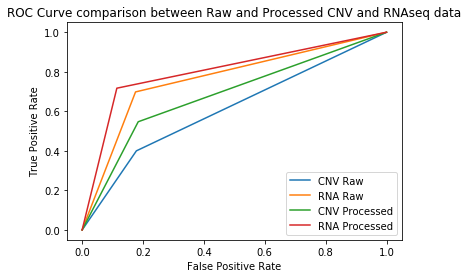

In [63]:
plt.plot(fpr_cnv, tpr_cnv, label = 'CNV Raw')
plt.plot(fpr_rna, tpr_rna, label = 'RNA Raw')
plt.plot(fpr_cnv_processed, tpr_cnv_processed, label = 'CNV Processed')
plt.plot(fpr_rna_processed, tpr_rna_processed, label = 'RNA Processed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve comparison between Raw and Processed CNV and RNAseq data')
plt.show()

In [ ]:
def roc_graph(data, title = 'ROC Curve')
    

In [ ]:
raw_and_processed_predictions = [
    [y_cnv_test, cnv_prediction, 'CNV Raw']
    [y_rna_test, rna_prediction, 'RNA Raw']
    
]

### Logistic Regression on combined CNV and RNAseq data (processed)

In [64]:
x_combined = pd.concat([x_cnv_processed.reset_index(drop = True), x_rna_processed.reset_index(drop = True)] , axis = 1)
y_combined = y[0]
x_combined.shape

(668, 52077)

In [65]:
#Visualise
x_combined[np.random.choice(x_combined.columns.values, size = 5, replace = False)].describe()

,16493,16493,8205,8205,873,873,15859,15859,9220,9220
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,-3.500194e-16,5.183811e-16,-1.379469e-16,-1.196024e-16,-9.928435e-17,-4.311255e-16,-1.579741e-16,7.064168e-16,-5.175501e-16,-4.479118e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.381573e+00,-1.383084e+00,-3.144554e+00,-1.064545e-01,-2.671816e+00,-6.924881e-01,-2.305606e+00,-9.914084e-01,-3.689500e+00,-2.248752e-01
25%,-7.027822e-01,-7.022032e-01,-6.602035e-01,-1.064545e-01,-5.767617e-01,-5.311156e-01,-5.996203e-01,-4.854270e-01,-5.813363e-01,-2.248752e-01
50%,6.248352e-02,-1.978384e-01,-1.704642e-01,-1.025256e-01,-2.630726e-02,-2.605268e-01,-1.554317e-01,-1.466499e-01,-5.545689e-02,-2.248752e-01
75%,4.932262e-01,4.108239e-01,5.665416e-01,-9.374705e-02,5.653483e-01,2.641445e-01,4.958265e-01,2.688852e-01,6.311043e-01,-1.430175e-01
max,3.361007e+00,8.168853e+00,4.408084e+00,2.112816e+01,3.870258e+00,1.758142e+01,9.094213e+00,1.537388e+01,4.858557e+00,1.554388e+01


In [66]:
#Split data into training and test sets
x_combined_train, x_combined_test, y_combined_train, y_combined_test = train_test_split(
    x_combined, y_combined.values.flatten(), test_size = 0.25, random_state = 0)

Combined_regression = LogisticRegression(penalty = 'l1',solver = 'liblinear', random_state = 0)
Combined_regression.fit(x_combined_train, y_combined_train)
Combined_regression.score(x_combined_test, y_combined_test)

0.8323353293413174

In [67]:
combined_prediction = Combined_regression.predict(x_combined_test)

#### Precision Recall Curve

In [68]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

In [69]:
precision, recall, _ = precision_recall_curve(y_combined_test, combined_prediction)

In [70]:
y_combined_test.sum()

53

In [71]:
combined_prediction.shape

(167,)

In [72]:
precision_recall = list(zip(precision,recall))

In [73]:
precision_recall

[(0.31736526946107785, 1.0),
 (0.7272727272727273, 0.7547169811320755),
 (1.0, 0.0)]

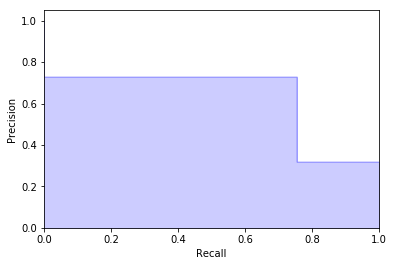

In [74]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

#### ROC Curve

In [ ]:
fpr_rna_raw, tpr_rna_raw, thresholds_rna_raw = roc_curve(y_)

In [195]:
fpr, tpr, thresholds = roc_curve(y_combined_test, combined_prediction)

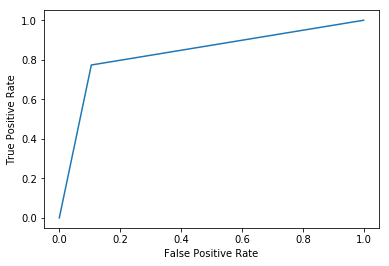

In [42]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [57]:
roc_auc_score(y_combined_test, combined_prediction)

0.8341608738828203

#### Confusion Matrix

In [45]:
confusion_matrix(y_combined_test, combined_prediction)

array([[102,  12],
       [ 12,  41]])

In [47]:
import seaborn as sns

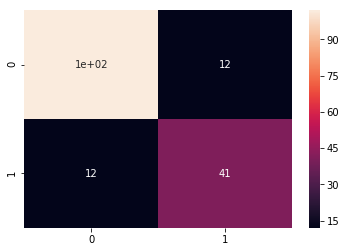

In [49]:
sns.heatmap(confusion_matrix(y_combined_test, combined_prediction), annot = True)

#### Grid Search

In [86]:
from sklearn.model_selection import GridSearchCV

In [164]:
#c_values = [0.001, 0.01, 1, 10, 100, 1000]
c_values = [1,5,6,7,8,9,10,11,12,13,14,15,20,50]
parameters = {'C': c_values, 'penalty': ['l1','l2'], 'solver': ['liblinear']}
clf = GridSearchCV(cv = 3, estimator = Combined_regression, param_grid = parameters)

In [165]:
clf.fit(x_combined_train, y_combined_train)

/Users/a.su/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [166]:
clf.best_score_

0.812375249500998

In [167]:
clf.score(x_combined_test, y_combined_test)

0.8203592814371258

In [168]:
clf.best_params_

{'C': 12, 'penalty': 'l1', 'solver': 'liblinear'}

#### Elastic Net

In [78]:
from sklearn.linear_model import SGDClassifier

In [81]:
SGD = SGDClassifier(alpha = 0.1, epsilon = 0.01, max_iter = 100, penalty = 'elasticnet')

In [82]:
SGD.fit(x_combined_train, y_combined_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.01, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
SGD.score(x_combined_test, y_combined_test)

0.7365269461077845

In [84]:
SGD_parameters = {'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty':['elasticnet'], 
                  'epsilon': [0.001, 0.01, 0.1, 1, 10]}

In [88]:
SGD_search = GridSearchCV(estimator = SGD, param_grid= SGD_parameters)

In [89]:
SGD_search.fit(x_combined_train, y_combined_train)

/Users/a.su/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
SGD_search.score(x_combined_test, y_combined_test)

In [ ]:
SGD_search.best_params_